In [11]:
## global parameters:
conservativeness_level = 0.5
starting_node = 0
starting_propagation_at_tick = 5000
propagation_interval = 20

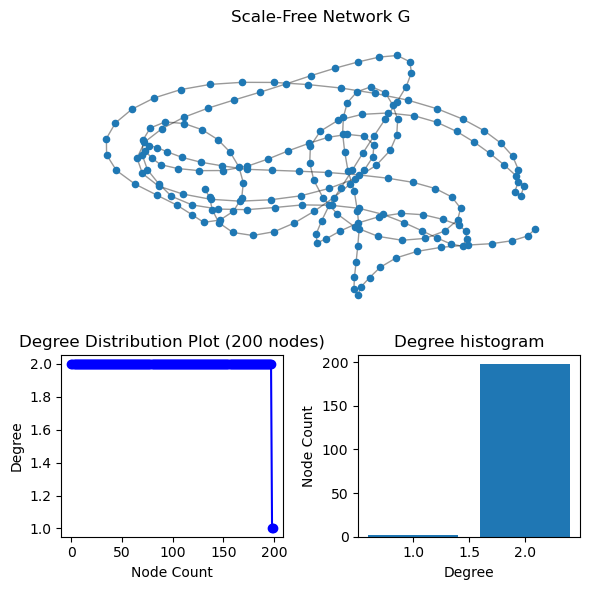

In [12]:
import networkx as nx
import json
import matplotlib.pyplot as plt
import numpy as np

# none for using default topology, str for using simulation config file
simulation_config = None

def generate_default_graph():
    line_graph_N = 200
    edges = []
    for i in range(line_graph_N-1):
        edges.append((i,i+1))
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

def load_simulation_config(config_file_path: str):
    config_file = open(config_file_path)
    config_file_content = config_file.read()
    config_file_json = json.loads(config_file_content)
    topology = config_file_json['node_topology']
    G = nx.Graph()
    for singleItem in topology:
        unDirLink = singleItem.split('--')
        if len(unDirLink) != 1:
            G.add_edge(unDirLink[0], unDirLink[1])
    return G

def save_network_info(graph: nx.Graph, enable_topology: bool = False):
    degree_sequence = sorted((d for n, d in graph.degree()), reverse=True)

    if enable_topology:
        fig = plt.figure("Degree of a random graph", figsize=(6, 6))
        axgrid = fig.add_gridspec(5, 4)
        ax0 = fig.add_subplot(axgrid[0:3, :])
        ax1 = fig.add_subplot(axgrid[3:, :2])
        ax2 = fig.add_subplot(axgrid[3:, 2:])
    else:
        fig = plt.figure("Degree of a random graph", figsize=(6, 3))
        axgrid = fig.add_gridspec(2, 4)
        ax1 = fig.add_subplot(axgrid[:, :2])
        ax2 = fig.add_subplot(axgrid[:, 2:])

    if enable_topology:
        Gcc = graph.subgraph(sorted(nx.connected_components(graph), key=len, reverse=True)[0])
        pos = nx.spring_layout(Gcc, seed=10396953)
        nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
        nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
        ax0.set_title("Scale-Free Network G")
        ax0.set_axis_off()

    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Distribution Plot ({size} nodes)".format(size=len(graph.nodes)))
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Node Count")

    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("Node Count")

    fig.tight_layout()


if simulation_config is None:
    G = generate_default_graph()
else:
    G = load_simulation_config(simulation_config)
save_network_info(G, True)

In [13]:
## get adjacent matrix
adjacent_matrix = nx.adjacency_matrix(G)
adjacent_matrix = adjacent_matrix.todense()
print(adjacent_matrix)

[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]


In [14]:
network_size = len(G.nodes)
transformation_matrix = np.zeros((network_size, network_size))
for single_node in G.nodes:
    if starting_node == single_node:
        transformation_matrix[starting_node,starting_node] = 1
    else:
        non_zero_count = np.count_nonzero(adjacent_matrix[single_node])
        self_weight = conservativeness_level
        whole_other_weight = 1 - conservativeness_level
        single_other_weight = whole_other_weight / non_zero_count
        transformation_matrix[single_node] = adjacent_matrix[single_node] * single_other_weight
        transformation_matrix[single_node,single_node] = self_weight

print(transformation_matrix)

[[1.   0.   0.   ... 0.   0.   0.  ]
 [0.25 0.5  0.25 ... 0.   0.   0.  ]
 [0.   0.25 0.5  ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.5  0.25 0.  ]
 [0.   0.   0.   ... 0.25 0.5  0.25]
 [0.   0.   0.   ... 0.   0.5  0.5 ]]


total_propagation_round=750


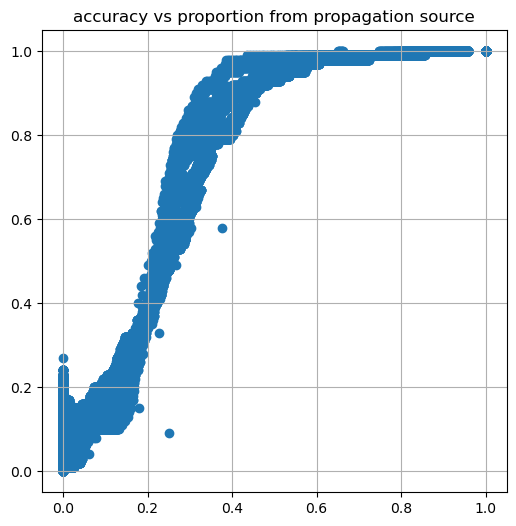

In [16]:
## load accuracy file
import pandas as pd
accuracy_df = pd.read_csv("./accuracy.csv")

total_ticks = accuracy_df['tick'].tail(1).iloc[0]
total_propagation_round = int((total_ticks - starting_propagation_at_tick) / propagation_interval)
print(f"total_propagation_round={total_propagation_round}")

transformation_matrix_powers = [np.linalg.matrix_power(transformation_matrix, i+1) for i in range(total_propagation_round)]

proportion_of_model = []
accuracy_of_model = []
for tick_index in range(total_propagation_round):
    tick = tick_index * propagation_interval + starting_propagation_at_tick
    accuracy_row = accuracy_df.loc[accuracy_df['tick'] == tick].iloc[0]
    for n in range(network_size):
        accuracy_of_model.append(accuracy_row[str(n)])
        proportion_of_model.append(transformation_matrix_powers[tick_index][n,0])

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("accuracy vs proportion from propagation source")
ax.scatter(proportion_of_model, accuracy_of_model)
ax.grid()

In [26]:
transformation_matrix_powers[-1][:,0]   # the proportion of propagation source at final tick

array([1.00000000e+00, 9.58831712e-01, 9.17772915e-01, 8.76932225e-01,
       8.36416527e-01, 7.96330135e-01, 7.56773986e-01, 7.17844883e-01,
       6.79634787e-01, 6.42230174e-01, 6.05711460e-01, 5.70152502e-01,
       5.35620180e-01, 5.02174066e-01, 4.69866169e-01, 4.38740784e-01,
       4.08834409e-01, 3.80175757e-01, 3.52785848e-01, 3.26678171e-01,
       3.01858925e-01, 2.78327318e-01, 2.56075929e-01, 2.35091112e-01,
       2.15353455e-01, 1.96838260e-01, 1.79516053e-01, 1.63353120e-01,
       1.48312035e-01, 1.34352209e-01, 1.21430422e-01, 1.09501345e-01,
       9.85180521e-02, 8.84324995e-02, 7.91959858e-02, 7.07595778e-02,
       6.30745038e-02, 5.60925115e-02, 4.97661885e-02, 4.40492453e-02,
       3.88967597e-02, 3.42653851e-02, 3.01135216e-02, 2.64014519e-02,
       2.30914452e-02, 2.01478292e-02, 1.75370340e-02, 1.52276105e-02,
       1.31902243e-02, 1.13976305e-02, 9.82462937e-03, 8.44800793e-03,
       7.24646802e-03, 6.20054474e-03, 5.29251681e-03, 4.50631127e-03,
      